# comparison with petitRadtrans H-

This code compares a CO emission spectrum (HITEMP) + Hminus between exojax and petitRadtran

last update: July 2nd (2021)

In [1]:
%load_ext autoreload
%autoreload 2
from exojax.spec import rtransfer as rt
from exojax.spec import planck
from exojax.spec import moldb
from exojax.spec import make_numatrix0
from exojax.spec.lpf import xsmatrix
from exojax.spec.hitran import SijT, doppler_sigma, gamma_hitran, gamma_natural
from exojax.plot.atmplot import plottau, plotcf
from exojax.spec.rtransfer import rtrun, rtrun_direct, dtauM, dtauHminus
from exojax.spec.hitrancia import read_cia, logacia 
from exojax.spec.hminus import log_hminus_continuum

import numpy as np
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

~/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import jax.numpy as jnp
from jax import random
from jax import vmap, jit
plt.style.use('bmh')

In [3]:
dat=pd.read_csv("petitcode/hminus/CO_Hminus_Linear.dat",delimiter=" ",names=("WAV","VAL"))

## INPUT MODEL

In [4]:
N=20000
wav=np.array(dat["WAV"].values*10000,dtype=np.float64)
#np.linspace(23000.0,24000.0,N,dtype=np.float64)#AA
nus=1.e8/wav[::-1]

#loading molecular database
mdbCO=moldb.MdbHit('~/exojax_/data/hitemp/CO/05_HITEMP2019.par',nus)

In [5]:
#petitRadtran

NP=130
Nspecies=160
Parr=np.ones(NP)
Tarr=np.ones(NP)

### read header
data = open('petitcode/co_exojax/Gl229/MMR/eq.dat', 'r')
line = data.read().split()
data.close()
molname = {}
for a in range(0,160):
    molname[a] = line[a+6]

data = open('petitcode/co_exojax/Gl229/MMR/eq.dat', 'r')
a = 0
for line in data:
    if line[0]=='#':
        continue
    lines = line.rstrip('\n').split()
    Parr[a] = lines[0]
    Tarr[a] = lines[1]
    a = a + 1
data.close()

Tarr=jnp.array(Tarr)
Parr=jnp.array(Parr)
Tarr=jnp.linspace(2000,3000,len(Tarr))

In [6]:
from exojax.utils.chopstacks import buildwall 
wParr=buildwall(Parr)
dParr=wParr[1:]-wParr[0:-1]

In [7]:
#partition function ratio
mdbCO_hitran=moldb.MdbHit('~/exojax_/data/CO/05_hit12.par',nus)

In [8]:
qr=mdbCO_hitran.Qr_HAPI(Tarr)

In [9]:
#partitioning Q(T) for each line
qt=np.zeros((NP,len(mdbCO.isoid)))
for idx,iso in enumerate(mdbCO.uniqiso):
    mask=mdbCO.isoid==iso
    for ilayer in range(NP):
        qt[ilayer,mask]=qr[ilayer,idx]

In [10]:
molmass=28.01 #molecular mass
mmr=0.01 #mass mixing ratio
g=1.e5 # gravity cm/s2

#vmr=mmr*mmw/molmass 
#mmw=2.33 #mean molecular weight

In [11]:
SijM=vmap(SijT,(0,None,None,None,0))(Tarr,mdbCO.logsij0,mdbCO.nu_lines\
                                          ,mdbCO.elower,qt)
gammaLM = vmap(gamma_hitran,(0,0,0,None,None,None))\
(Parr,Tarr,Parr, mdbCO.n_air, mdbCO.gamma_air, mdbCO.gamma_self)
+ gamma_natural(mdbCO.A) #uncomment if you inclide a natural width
sigmaDM=vmap(doppler_sigma,(None,0,None))(mdbCO.nu_lines,Tarr,molmass)

In [27]:
from exojax.spec import molinfo
mmw=2.33 #mean molecular weight
molmassH=molinfo.molmass("H")
mmrh=0.0001
vmrh=(mmrh*mmw/molmassH)*np.ones(NP)
vmre=vmrh

In [29]:
dtauhm=dtauHminus(nus,Tarr,Parr,dParr,vmre,vmrh,mmw,g)

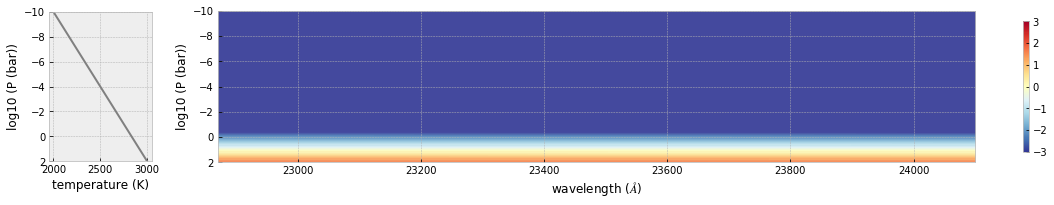

In [30]:
plottau(nus,dtauhm,Tarr,Parr,unit="AA")

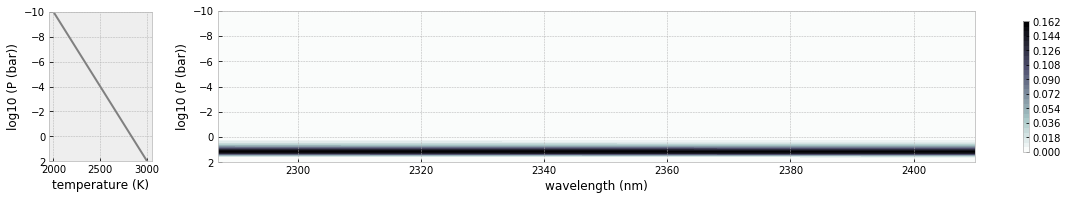

In [31]:
plotcf(nus,dtauhm,Tarr,Parr,dParr,unit="nm") 
plt.savefig("cf.png")
plt.show()

In [17]:
#Looks a bit low

In [20]:
nu0=mdbCO.nu_lines
memory_size=15.0

d=int(memory_size/(len(nu0)*4/1024./1024.))
Ni=int(len(nus)/d)

d2=100
Nlayer=np.shape(SijM)[0]
Nline=np.shape(SijM)[1]
Nj=int(Nline/d2)
xsm=[]
for i in tqdm.tqdm(range(0,Ni+1)):
    s=int(i*d);e=int((i+1)*d);e=min(e,len(nus))
    xsmtmp=np.zeros((Nlayer,e-s))
    #line 
    for j in range(0,Nj+1):
        s2=int(j*d2);e2=int((j+1)*d2);e2=min(e2,Nline)
        numatrix=make_numatrix0(nus[s:e],nu0[s2:e2])
        xsmtmp=xsmtmp+\
        xsmatrix(numatrix,sigmaDM[:,s2:e2],gammaLM[:,s2:e2],SijM[:,s2:e2])
    if i==0:
        xsm=np.copy(xsmtmp.T)
    else:
        xsm = np.concatenate([xsm,xsmtmp.T])
xsm=xsm.T



100%|██████████| 207/207 [03:01<00:00,  1.32s/it]


In [35]:
dtau=dtauM(dParr,xsm,mmr*np.ones_like(Parr),molmass,g)+dtauhm

## cheking d tau and contribution function

DeviceArray([[1.7476556e-12, 1.9072403e-11, 6.8236215e-11, ...,
              7.1986560e-25, 7.1869040e-25, 7.1719181e-25],
             [2.2525352e-12, 2.4356453e-11, 8.6713317e-11, ...,
              1.2188163e-24, 1.2170730e-24, 1.2148470e-24],
             [2.9022967e-12, 3.1096178e-11, 1.1016850e-10, ...,
              2.1272593e-24, 2.1246651e-24, 2.1213564e-24],
             ...,
             [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
              0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
             [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
              0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
             [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
              0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],            dtype=float32)

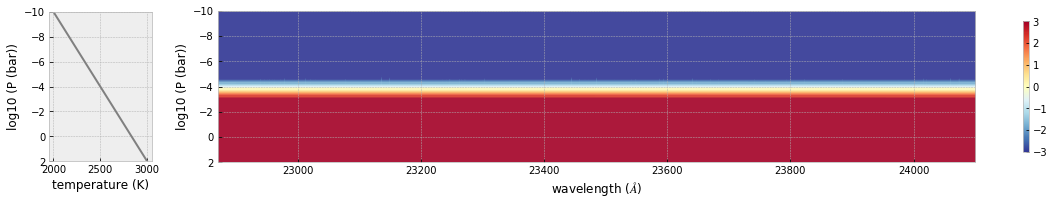

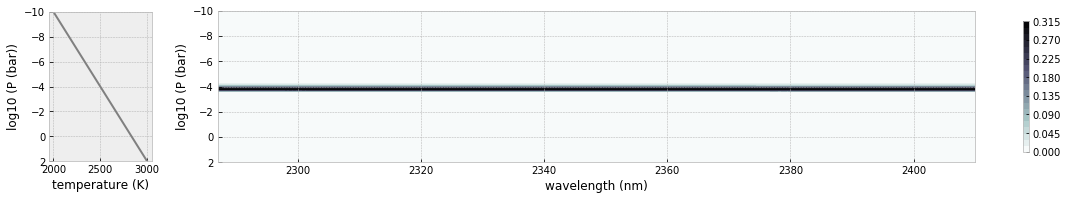

In [36]:
plottau(nus,dtau,Tarr,Parr,unit="AA") #tau
#from exojax.plot.atmplot import plottau, plotcf
plotcf(nus,dtau,Tarr,Parr,dParr,unit="nm") 
#plt.savefig("cf.pdf", bbox_inches="tight", pad_inches=0.0)

In [50]:
sourcef=planck.piBarr(Tarr,nus)
Fx0=rtrun(dtau,sourcef) #flux in the unit of erg/cm2/s/cm
#Fx0_direct=rtrun_direct(dtauM,sourcef) #mu=1
#Fx0_direct=rtrun_direct(dtauM/0.5,sourcef) #mu=0.5

In [38]:
ccgs=29979245800.0
Fx0=Fx0/ccgs #convert to the unit of erg/cm2/s/Hz

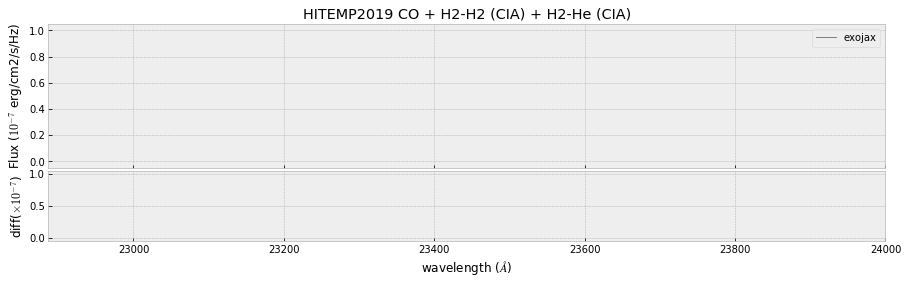

In [40]:
#dat=pd.read_csv("co_exojax/Gl229/Gl229B_spectrum_CO_CIA_Linear.dat",delimiter=" ",names=("WAV","VAL"))

fig=plt.figure(figsize=(15,4))
ax=plt.subplot2grid((12, 1), (0, 0),rowspan=8)
plt.plot(1.e8/nus,Fx0*1.e7,lw=1,alpha=1.0,label="exojax",color="gray")
#plt.plot(1.e4/nus,Fx0_direct,lw=1,alpha=1.0,label="exojax direct $\mu=1$",color="C2")
#plt.plot(dat["WAV"],dat["VAL"],lw=1,alpha=0.9,label="petitRadtran")

### ISO LINE
if False:
    Smax=(np.max(SijM,axis=0))
    crit=-24
    for iso in mdbCO.uniqiso:
        mask=(mdbCO.isoid==iso)*(np.log10(Smax)>crit)
        wiso=1.e4/nu0[mask]
        for w in wiso:
            plt.axvline(w,color="C"+str(iso),alpha=0.1)

    #iso just for label
    for iso in mdbCO.uniqiso:
        plt.axvline([1.0],color="C"+str(iso),alpha=0.3,label="iso="+str(iso))
###

plt.xlim(22887,24000)
#plt.yscale("log")
#plt.ylim(0.0,2.0)
plt.ylabel("Flux ($10^{-7}$ erg/cm2/s/Hz)")
plt.title("HITEMP2019 CO + H2-H2 (CIA) + H2-He (CIA)")
plt.legend()
plt.xticks(color="None")
#ax=fig.add_subplot(212)
ax=plt.subplot2grid((12, 1), (8, 0),rowspan=4)
plt.plot(1.e8/nus,(Fx0-dat["VAL"][::-1])*1.e7,lw=1,alpha=1.0,label="exojax",color="gray")
#plt.ylim(-0.5,0.499)
plt.xlim(22887,24000)
plt.ylabel("diff($\\times 10^{-7}$)")
plt.xlabel("wavelength ($\\AA$)")
plt.savefig("comp_petit_linear.png", bbox_inches="tight", pad_inches=0.0)
plt.savefig("comp_petit_linear.pdf", bbox_inches="tight", pad_inches=0.0)